# Assignment 3

**Submission deadlines:**

  - Tuesday groups: 22.04.2025
  - Friday groups: 18.04.2025

**Points:** Aim to get 10 points + 4 extra

## Submission instructions
The class is held on-site in lab rooms. Please prepare you notebook on your computer or anywhere in the cloud (try using DeepNote or Google Colab).

Make sure you know all the questions and answers, and that the notebook contains results; before presentation do `Runtime -> Restart and run all`

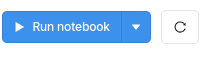

We provide starter code, however you are not required to use it as long as you properly solve the tasks.

# Classify the Oxford Flowers dataset (Weight & Biases) [6p]

In this task, you will train a convolutional neural network to classify images of flowers from the [Oxford Flowers 102 dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/). The dataset consists of 102 flower categories, and each class has between 40 and 258 images. The images have large scale, pose, and light variations. In addition, there are categories that have large variations within the category and several very similar categories.

    
The dataset is available in `torchvision.datasets.Flowers102` class; see [Flowers102.html](https://pytorch.org/vision/main/generated/torchvision.datasets.Flowers102.html). You can use the following code to load the dataset:

```python
import torchvision
import torchvision.transforms as transforms

dataset = torchvision.datasets.Flowers102(root='./data', download=True, transform=transforms.ToTensor())
```

**Hint**: The default split of the dataset is 1020, 1020 and 6149 images for training, validation and test sets respectively.
If you can handle the bigger training dataset, you can experiment by taking up to 80% of the test set for training.


In this task you should run several experiments to classify the images.
In order to track the experiments, you can use the `Weight & Biases` library; see the [documentation](https://docs.wandb.ai/quickstart) for more details.

Implement your code as a single Python script or a Jupyter notebook. Remember to log the experiment configuration, hyperparameters, and results (e.g., training loss, validation loss, accuracy and test loss, accuracy).
For logging, you can use the `wandb.log` function to log the metrics and hyperparameters. You can also log the model architecture, training curves, and other relevant information.

* 1. **[1p]**:
    * Your task is to implement a convolutional neural network from scratch using PyTorch.
    * Your CNN should consist of convolutional layers (Conv2D), pooling layers (MaxPooling2D), activation layers (e.g., ReLU), and fully connected layers (if needed).
    
* 2. **[2p]**:
    * Train your CNN on different training set sized (10%, 20%, 50%, 80%, 100%) and evaluate the performance on the validation set and test set.
        * Report the accuracy and loss on the validation set and test set for each training set size.
    * Train your CNN on the full training set plus 20%, 50% and 80% of the test set and evaluate the performance on the validation set and the remaining test set.
        * Report the accuracy and loss on the validation set and remaining test set for each training set size.
    * Compare the performance of your CNN on the different training set sizes and analyze the results.

* 3. **[1p]**:
    * Implement a baseline AlexNet model using PyTorch.
    * Training AlexNet may take a long time, so try to use GPU acceleration if available.

* 4. **[1p]**:
    * Input normalization: experiment with different input normalization techniques (e.g., mean subtraction, standardization) and analyze their impact on the model's performance.

* 5. **[2p]**:
    * Experiment with different hyperparameters such as learning rate, batch size, number of epochs, and optimizer choice (e.g., SGD, Adam).

* 6. **[2p]**:
    * Modify your CNN architecture to include batch normalization and dropout layers.
    * Experiment with different dropout rates and analyze their impact on the model's performance.

* 7. **[1p]**:
    * Implement data augmentation techniques such as random rotations, shifts, flips, and zooms on the training dataset.
    * Train your CNN with augmented data and compare the performance with the baseline model trained on the original data.

* 8. ***[2p extra points]***:
    * Implement residual connections in your CNN architecture; see the [ResNet paper](https://arxiv.org/abs/1512.03385) for more details.
    * Implement inception modules in your CNN architecture; see the [GoogLeNet paper](https://arxiv.org/abs/1409.4842) for more details.
                

Analyze the results obtained from different experiments.
Discuss the effects of varying training set size, hyperparameters, batch normalization, dropout, and data augmentation on the CNN's performance.
Provide insights into how these factors influence model training, convergence, and generalization.

Use the `Weight & Biases` reports to present your findings in a comprehensive report or presentation; see the [documentation](https://docs.wandb.ai/quickstart) for more details.

**[2p extra]**: present your findings (for each task) in a report format in Weight & Biases.




In [ ]:
import torch
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision.datasets import Flowers102
import torchvision.transforms as transforms
from collections import defaultdict
import numpy as np
import random
from PIL import ImageOps


class Flowers102DataLoader:
    def __init__(self, data_dir='./data', batch_size=32, shuffle=True):
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

        self.train_dataset = Flowers102(root=data_dir, split='train', download=True, transform=self.transform)
        self.val_dataset = Flowers102(root=data_dir, split='val', download=True, transform=self.transform)
        self.test_dataset = Flowers102(root=data_dir, split='test', download=True, transform=self.transform)

        self.batch_size = batch_size
        self.shuffle = shuffle

        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=shuffle)
        self.val_loader = DataLoader(self.val_dataset, batch_size=batch_size, shuffle=False)
        self.test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)

    def _get_targets(self, dataset):
        if isinstance(dataset, ConcatDataset):
            targets = []
            for d in dataset.datasets:
                targets.extend(self._get_targets(d))
            return targets
        elif isinstance(dataset, Subset):
            parent_targets = self._get_targets(dataset.dataset)
            return [parent_targets[i] for i in dataset.indices]
        elif hasattr(dataset, '_labels'):
            return dataset._labels
        else:
            raise AttributeError("Nie można znaleźć etykiet w podanym zbiorze danych.")

    def _stratified_sample_indices(self, targets, percent):
        targets = np.array(targets)
        indices_by_class = defaultdict(list)

        for idx, label in enumerate(targets):
            indices_by_class[label].append(idx)

        sampled_indices = []
        for label, indices in indices_by_class.items():
            n_samples = max(1, int(len(indices) * percent))
            sampled = random.sample(indices, n_samples)
            sampled_indices.extend(sampled)

        return sampled_indices

    def set_partial_train_set(self, percent=0.5):
        assert 0 < percent <= 1, "Procent musi być w przedziale (0, 1]"
        targets = self._get_targets(self.train_dataset)
        indices = self._stratified_sample_indices(targets, percent)
        subset = Subset(self.train_dataset, indices)
        self.train_dataset = subset
        self.train_loader = DataLoader(subset, batch_size=self.batch_size, shuffle=self.shuffle)

    def move_test_to_train(self, percent=0.2):
        assert 0 < percent <= 1, "percentage must by less than 1 and greater than 0"
        targets = self._get_targets(self.test_dataset)
        move_indices = self._stratified_sample_indices(targets, percent)

        all_indices = set(range(len(self.test_dataset)))
        remain_indices = list(all_indices - set(move_indices))

        moved_subset = Subset(self.test_dataset, move_indices)
        remaining_test = Subset(self.test_dataset, remain_indices)

        self.train_dataset = ConcatDataset([self.train_dataset, moved_subset])
        self.test_dataset = remaining_test

        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=self.shuffle)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

    def get_loaders(self):
        return self.train_loader, self.val_loader, self.test_loader

    def print_class_distribution(self, split='train'):
        dataset_map = {
            'train': self.train_dataset,
            'val': self.val_dataset,
            'test': self.test_dataset,
        }
        assert split in dataset_map, f"Nieznany split: {split}"

        targets = self._get_targets(dataset_map[split])
        unique, counts = np.unique(targets, return_counts=True)
        print(f"Rozkład klas dla '{split}':")
        for label, count in zip(unique, counts):
            print(f"  Klasa {label:3d}: {count} próbek")

    def print_loader_sizes(self):
        def get_len(dataset):
            return len(dataset)

        print("Rozmiary zbiorów danych:")
        print(f"  🟦 Train: {get_len(self.train_dataset)} próbek")
        print(f"  🟨 Val:   {get_len(self.val_dataset)} próbek")
        print(f"  🟥 Test:  {get_len(self.test_dataset)} próbek")


In [ ]:
loader = Flowers102DataLoader(batch_size=64)
loader.print_loader_sizes()
loader.set_partial_train_set(percent=0.8)
loader.print_loader_sizes()



100%|██████████| 345M/345M [00:18<00:00, 18.8MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.13MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 22.6MB/s]


Rozmiary zbiorów danych:
  🟦 Train: 1020 próbek
  🟨 Val:   1020 próbek
  🟥 Test:  6149 próbek
Rozmiary zbiorów danych:
  🟦 Train: 816 próbek
  🟨 Val:   1020 próbek
  🟥 Test:  6149 próbek


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=102):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
            )
        self.features = nn.Sequential(
            conv_block(3,   32),   # → 32×112×112
            conv_block(32,  64),   # → 64×56×56
            conv_block(64, 128),   # → 128×28×28
            conv_block(128,256),   # → 256×14×14
            nn.AdaptiveAvgPool2d((1,1))  # → 256×1×1
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [ ]:
import torch.nn as nn

class SimpleCNNDroput(nn.Module):
    def __init__(self, num_classes=102, dropout_p=0.25):
        super().__init__()

        def conv_block(in_c, out_c, dropout_p=dropout_p):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Dropout2d(p=dropout_p)
            )

        self.features = nn.Sequential(
            conv_block(3,   32),    # → 32×112×112
            conv_block(32,  64),    # → 64×56×56
            conv_block(64, 128),    # → 128×28×28
            conv_block(128, 256),   # → 256×14×14
            nn.AdaptiveAvgPool2d((1, 1))  # → 256×1×1
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class Trainer:
    def __init__(self, model, train_loader, val_loader, test_loader, config):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

        self.criterion = nn.CrossEntropyLoss()

        if config['optimizer'] == 'adam':
            self.optimizer = optim.Adam(model.parameters(), lr=config['lr'])
        else:
            self.optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)

        self.epochs = config['epochs']
        self.config = config

        self.run = wandb.init(
            project="flowers102-cnn-batch mixed parameters2",
            name=config.get('run_name'),
            tags=config.get('tags'),
            group=config.get('group'),
            config=config,
            reinit=True)

    def train(self):
        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for images, labels in tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.epochs}"):
                images, labels = images.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            acc = 100. * correct / total
            val_loss, val_acc = self.evaluate(self.val_loader)
            print(f"Val acc: {val_acc:.2f}%, loss: {val_loss:.4f}")


            wandb.log({
                "epoch": epoch + 1,
                "train_loss": running_loss / len(self.train_loader),
                "train_acc": acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            })

    def evaluate(self, loader):
        self.model.eval()
        total = 0
        correct = 0
        total_loss = 0.0

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        acc = 100. * correct / total
        avg_loss = total_loss / len(loader)
        return avg_loss, acc

    def test(self):
        test_loss, test_acc = self.evaluate(self.test_loader)
        wandb.log({"test_loss": test_loss, "test_acc": test_acc})
        self.run.finish()
        print(f"Test acc: {test_acc:.2f}%, loss: {test_loss:.4f}")

In [ ]:
def run_experiment(config, model):
    data_module = Flowers102DataLoader(batch_size=config['batch_size'])

    if config.get("train_percent", 1.0) < 1.0:
        data_module.set_partial_train_set(config["train_percent"])

    if config.get("move_test_to_train", 0.0) > 0.0:
        data_module.move_test_to_train(config["move_test_to_train"])

    train_loader, val_loader, test_loader = data_module.get_loaders()

    model = model
    trainer = Trainer(model, train_loader, val_loader, test_loader, config)
    trainer.train()
    trainer.test()

In [ ]:

def build_config(batch_size = 64, epochs = 10, lr = 1e-3, optimizer = "adam", train_percent = 1.0, move_test_to_train = 0.0, dropout_p = 0.0):
  config = {
    'tags':       ['cnn', 'flowers102', 'baseline'],
    'group':      f'partial-train{train_percent}',
    'epochs':     epochs,
    'lr':         lr,
    'optimizer':  optimizer,
    'batch_size': batch_size,
    'train_percent': train_percent,
    'move_test_to_train': move_test_to_train}

  config['run_name'] = (
    f"cnn_bs{config['batch_size']}"
    f"_lr{config['lr']}"
    f"_opt{config['optimizer']}"
    f"_ep{config['epochs']}")

  return config


## Task2

In [ ]:
config1 = build_config(batch_size = 64, epochs = 10,
                      lr = 1e-3, optimizer = "adam", train_percent = 0.1,
                      move_test_to_train = 0.0)

config2 = build_config(batch_size = 64, epochs = 10,
                      lr = 1e-3, optimizer = "adam", train_percent = 0.2,
                      move_test_to_train = 0.0)

config3 = build_config(batch_size = 64, epochs = 10,
                      lr = 1e-3, optimizer = "adam", train_percent = 0.5,
                      move_test_to_train = 0.0)

config4 = build_config(batch_size = 64, epochs = 10,
                      lr = 1e-3, optimizer = "adam", train_percent = 0.8,
                      move_test_to_train = 0.0)

config5 = build_config(batch_size = 64, epochs = 10,
                      lr = 1e-3, optimizer = "adam", train_percent = 1,
                      move_test_to_train = 0.0)

config6 = build_config(batch_size = 64, epochs = 10,
                      lr = 1e-3, optimizer = "adam", train_percent = 1,
                      move_test_to_train = 0.2)

config7 = build_config(batch_size = 64, epochs = 10,
                      lr = 1e-3, optimizer = "adam", train_percent = 1,
                      move_test_to_train = 0.5)

config8 = build_config(batch_size = 64, epochs = 10,
                      lr = 1e-3, optimizer = "adam", train_percent = 1,
                      move_test_to_train = 0.8)

# run_experiment(config1, SimpleCNN(num_classes=102))
# run_experiment(config2, SimpleCNN(num_classes=102))
# run_experiment(config3, SimpleCNN(num_classes=102))
# run_experiment(config4, SimpleCNN(num_classes=102))
# run_experiment(config5, SimpleCNN(num_classes=102))
# run_experiment(config6, SimpleCNN(num_classes=102))
# run_experiment(config7, SimpleCNN(num_classes=102))
# run_experiment(config8, SimpleCNN(num_classes=102))

## Task3

## Task4

In [ ]:
# config = build_config(batch_size = 64, epochs = 10,
#                       lr = 1e-3, optimizer = "adam", train_percent = 1,
#                       move_test_to_train = 0.0)

# run_experiment(config, SimpleCNN(num_classes=102))

## Task6

In [ ]:

# for dropout_p in [0.1 + i*0.05 for i in range(15)]:
#     config = build_config(batch_size = 64, epochs = 10,
#                       lr = 1e-3, optimizer = "adam", train_percent = 1,
#                       move_test_to_train = 0.0, dropout_p = dropout_p)
#     run_experiment(config, SimpleCNNDroput(num_classes=102, dropout_p=dropout_p))


## Task5

In [ ]:
lr_rates = [0.001, 0.01, 0.005]
optimizer_types = ['adam', 'sgd']
epochs = [10,15,20]
batch_sizes = [32,48,64,80]

for lr in lr_rates:
    for opt in optimizer_types:
        for ep in epochs:
            for batch_size in batch_sizes:
                config = build_config(batch_size = batch_size, epochs = ep,
                      lr = lr, optimizer = opt, train_percent = 1,
                      move_test_to_train = 0.0)
                run_experiment(config, SimpleCNN(num_classes=102))



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: budzynekm09 (budzynekm09-uniwersytet-wroc-awski) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/10: 100%|██████████| 32/32 [00:10<00:00,  3.18it/s]


Val acc: 9.61%, loss: 3.9860


Epoch 2/10: 100%|██████████| 32/32 [00:08<00:00,  3.59it/s]


Val acc: 14.51%, loss: 3.7199


Epoch 3/10: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]


Val acc: 17.25%, loss: 3.5049


Epoch 4/10: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Val acc: 21.57%, loss: 3.3446


Epoch 5/10: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


Val acc: 23.33%, loss: 3.2666


Epoch 6/10: 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


Val acc: 26.86%, loss: 3.1229


Epoch 7/10: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s]


Val acc: 26.86%, loss: 3.0475


Epoch 8/10: 100%|██████████| 32/32 [00:08<00:00,  3.60it/s]


Val acc: 28.04%, loss: 2.9538


Epoch 9/10: 100%|██████████| 32/32 [00:08<00:00,  3.94it/s]


Val acc: 30.98%, loss: 2.8996


Epoch 10/10: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Val acc: 33.92%, loss: 2.8175


epoch,▁▂▃▃▄▅▆▆▇█
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▅▆▆▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▂▃▄▅▆▆▆▇█
val_loss,█▆▅▄▄▃▂▂▁▁
epoch,10
test_acc,26.76858
test_loss,3.00821
train_acc,39.31373


Test acc: 26.77%, loss: 3.0082


Epoch 1/10: 100%|██████████| 22/22 [00:08<00:00,  2.59it/s]


Val acc: 7.65%, loss: 4.0964


Epoch 2/10: 100%|██████████| 22/22 [00:07<00:00,  2.83it/s]


Val acc: 15.59%, loss: 3.7276


Epoch 3/10: 100%|██████████| 22/22 [00:07<00:00,  2.85it/s]


Val acc: 21.96%, loss: 3.4683


Epoch 4/10: 100%|██████████| 22/22 [00:08<00:00,  2.57it/s]


Val acc: 20.29%, loss: 3.3760


Epoch 5/10: 100%|██████████| 22/22 [00:08<00:00,  2.58it/s]


Val acc: 24.80%, loss: 3.2203


Epoch 6/10: 100%|██████████| 22/22 [00:08<00:00,  2.58it/s]


Val acc: 25.10%, loss: 3.1525


Epoch 7/10: 100%|██████████| 22/22 [00:08<00:00,  2.59it/s]


Val acc: 29.41%, loss: 3.0453


Epoch 8/10: 100%|██████████| 22/22 [00:07<00:00,  2.78it/s]


Val acc: 27.75%, loss: 2.9665


Epoch 9/10: 100%|██████████| 22/22 [00:08<00:00,  2.71it/s]


Val acc: 30.39%, loss: 2.8677


Epoch 10/10: 100%|██████████| 22/22 [00:08<00:00,  2.51it/s]


Val acc: 28.43%, loss: 2.9347


epoch,▁▂▃▃▄▅▆▆▇█
test_acc,▁
test_loss,▁
train_acc,▁▃▄▅▅▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▅▆▆█▇█▇
val_loss,█▆▄▄▃▃▂▂▁▁
epoch,10
test_acc,25.69523
test_loss,3.05585
train_acc,41.27451


Test acc: 25.70%, loss: 3.0558


Epoch 1/10: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


Val acc: 8.04%, loss: 4.2790


Epoch 2/10: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


Val acc: 13.92%, loss: 3.8647


Epoch 3/10: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Val acc: 21.27%, loss: 3.5961


Epoch 4/10: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Val acc: 21.37%, loss: 3.4624


Epoch 5/10: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Val acc: 25.78%, loss: 3.3173


Epoch 6/10: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


Val acc: 25.29%, loss: 3.2662


Epoch 7/10: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Val acc: 27.84%, loss: 3.1431


Epoch 8/10: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Val acc: 28.14%, loss: 3.0880


Epoch 9/10: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Val acc: 31.57%, loss: 2.9966


Epoch 10/10: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


Val acc: 29.61%, loss: 2.9934


epoch,▁▂▃▃▄▅▆▆▇█
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▅▆▇▇▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▅▆▆▇▇█▇
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
test_acc,23.62986
test_loss,3.19625
train_acc,42.94118


Test acc: 23.63%, loss: 3.1962


Epoch 1/10: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Val acc: 7.16%, loss: 4.2793


Epoch 2/10: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


Val acc: 12.25%, loss: 3.9651


Epoch 3/10: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]


Val acc: 17.84%, loss: 3.7426


Epoch 4/10: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


Val acc: 23.63%, loss: 3.5528


Epoch 5/10: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Val acc: 25.10%, loss: 3.4173


Epoch 6/10: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Val acc: 26.67%, loss: 3.2354


Epoch 7/10: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


Val acc: 25.59%, loss: 3.1871


Epoch 8/10: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


Val acc: 30.59%, loss: 3.0813


Epoch 9/10: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Val acc: 31.96%, loss: 2.9601


Epoch 10/10: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


Val acc: 31.18%, loss: 2.9477


epoch,▁▂▃▃▄▅▆▆▇█
test_acc,▁
test_loss,▁
train_acc,▁▂▃▅▅▆▇▇██
train_loss,█▆▅▄▄▃▃▂▂▁
val_acc,▁▂▄▆▆▇▆███
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
test_acc,27.14262
test_loss,3.07253
train_acc,41.86275


Test acc: 27.14%, loss: 3.0725


Epoch 1/15: 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


Val acc: 9.31%, loss: 3.9964


Epoch 2/15: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]


Val acc: 13.04%, loss: 3.7361


Epoch 3/15: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


Val acc: 20.39%, loss: 3.4407


Epoch 4/15: 100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


Val acc: 25.20%, loss: 3.2844


Epoch 5/15: 100%|██████████| 32/32 [00:08<00:00,  3.60it/s]


Val acc: 26.47%, loss: 3.1671


Epoch 6/15: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s]


Val acc: 26.96%, loss: 3.0323


Epoch 7/15: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Val acc: 27.94%, loss: 2.9936


Epoch 8/15: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


Val acc: 30.10%, loss: 2.8496


Epoch 9/15: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]


Val acc: 32.45%, loss: 2.8081


Epoch 10/15: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]


Val acc: 32.25%, loss: 2.7857


Epoch 11/15: 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


Val acc: 34.51%, loss: 2.7636


Epoch 12/15: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


Val acc: 36.08%, loss: 2.6927


Epoch 13/15: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]


Val acc: 35.88%, loss: 2.6972


Epoch 14/15: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s]


Val acc: 37.94%, loss: 2.6147


Epoch 15/15: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s]


Val acc: 36.96%, loss: 2.5753


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▅▅▅▆▆▇▇▇▇██
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▁▁
val_acc,▁▂▄▅▅▅▆▆▇▇▇█▇██
val_loss,█▇▅▄▄▃▃▂▂▂▂▂▂▁▁
epoch,15
test_acc,33.07855
test_loss,2.75204
train_acc,48.43137


Test acc: 33.08%, loss: 2.7520


Epoch 1/15: 100%|██████████| 22/22 [00:08<00:00,  2.53it/s]


Val acc: 10.98%, loss: 4.0808


Epoch 2/15: 100%|██████████| 22/22 [00:08<00:00,  2.57it/s]


Val acc: 15.98%, loss: 3.7407


Epoch 3/15: 100%|██████████| 22/22 [00:08<00:00,  2.54it/s]


Val acc: 22.35%, loss: 3.5548


Epoch 4/15: 100%|██████████| 22/22 [00:08<00:00,  2.70it/s]


Val acc: 23.73%, loss: 3.3802


Epoch 5/15: 100%|██████████| 22/22 [00:07<00:00,  2.79it/s]


Val acc: 27.06%, loss: 3.2040


Epoch 6/15: 100%|██████████| 22/22 [00:08<00:00,  2.65it/s]


Val acc: 24.41%, loss: 3.1516


Epoch 7/15: 100%|██████████| 22/22 [00:08<00:00,  2.57it/s]


Val acc: 29.02%, loss: 3.0282


Epoch 8/15: 100%|██████████| 22/22 [00:08<00:00,  2.55it/s]


Val acc: 31.27%, loss: 2.9656


Epoch 9/15: 100%|██████████| 22/22 [00:08<00:00,  2.56it/s]


Val acc: 30.98%, loss: 2.9007


Epoch 10/15: 100%|██████████| 22/22 [00:07<00:00,  2.81it/s]


Val acc: 32.16%, loss: 2.8510


Epoch 11/15: 100%|██████████| 22/22 [00:08<00:00,  2.73it/s]


Val acc: 30.20%, loss: 2.8630


Epoch 12/15: 100%|██████████| 22/22 [00:08<00:00,  2.55it/s]


Val acc: 32.35%, loss: 2.7913


Epoch 13/15: 100%|██████████| 22/22 [00:08<00:00,  2.56it/s]


Val acc: 33.82%, loss: 2.7642


Epoch 14/15: 100%|██████████| 22/22 [00:08<00:00,  2.56it/s]


Val acc: 33.14%, loss: 2.7676


Epoch 15/15: 100%|██████████| 22/22 [00:08<00:00,  2.71it/s]


Val acc: 33.73%, loss: 2.7197


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▅▅▆▆▆▆▇▇▇██
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▁▁
val_acc,▁▃▄▅▆▅▇▇▇▇▇████
val_loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁
epoch,15
test_acc,28.5087
test_loss,2.93401
train_acc,49.21569


Test acc: 28.51%, loss: 2.9340


Epoch 1/15: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Val acc: 9.90%, loss: 4.2394


Epoch 2/15: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Val acc: 14.31%, loss: 3.8446


Epoch 3/15: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Val acc: 20.20%, loss: 3.6013


Epoch 4/15: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


Val acc: 24.80%, loss: 3.4289


Epoch 5/15: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


Val acc: 25.59%, loss: 3.3347


Epoch 6/15: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Val acc: 26.18%, loss: 3.2252


Epoch 7/15: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Val acc: 26.86%, loss: 3.0959


Epoch 8/15: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Val acc: 29.12%, loss: 3.0424


Epoch 9/15: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


Val acc: 32.06%, loss: 2.9193


Epoch 10/15: 100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


Val acc: 28.73%, loss: 2.9699


Epoch 11/15: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Val acc: 32.75%, loss: 2.8113


Epoch 12/15: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Val acc: 31.76%, loss: 2.8161


Epoch 13/15: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Val acc: 35.10%, loss: 2.7180


Epoch 14/15: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Val acc: 33.14%, loss: 2.7353


Epoch 15/15: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]


Val acc: 34.41%, loss: 2.6868


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▅▅▆▆▆▇▇▇▇▇█
train_loss,█▆▆▅▄▄▃▃▃▂▂▂▁▁▁
val_acc,▁▂▄▅▅▆▆▆▇▆▇▇█▇█
val_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁
epoch,15
test_acc,30.63913
test_loss,2.88045
train_acc,51.27451


Test acc: 30.64%, loss: 2.8805


Epoch 1/15: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Val acc: 5.29%, loss: 4.2957


Epoch 2/15: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Val acc: 13.82%, loss: 3.8650


Epoch 3/15: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Val acc: 20.00%, loss: 3.6351


Epoch 4/15: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


Val acc: 22.06%, loss: 3.4822


Epoch 5/15: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


Val acc: 22.84%, loss: 3.3900


Epoch 6/15: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Val acc: 25.98%, loss: 3.2701


Epoch 7/15: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


Val acc: 25.69%, loss: 3.2129


Epoch 8/15: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Val acc: 28.53%, loss: 3.0738


Epoch 9/15: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Val acc: 27.16%, loss: 3.0681


Epoch 10/15: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Val acc: 31.57%, loss: 2.9376


Epoch 11/15: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Val acc: 32.65%, loss: 2.8892


Epoch 12/15: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


Val acc: 33.63%, loss: 2.8400


Epoch 13/15: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


Val acc: 35.10%, loss: 2.7583


Epoch 14/15: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


Val acc: 34.22%, loss: 2.7932


Epoch 15/15: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


Val acc: 34.41%, loss: 2.7564


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▄▅▅▆▆▇▇▇▇██
train_loss,█▆▆▅▄▄▃▃▃▂▂▂▁▁▁
val_acc,▁▃▄▅▅▆▆▆▆▇▇████
val_loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁
epoch,15
test_acc,30.13498
test_loss,2.91606
train_acc,50.98039


Test acc: 30.13%, loss: 2.9161


Epoch 1/20: 100%|██████████| 32/32 [00:09<00:00,  3.54it/s]


Val acc: 11.57%, loss: 3.9979


Epoch 2/20: 100%|██████████| 32/32 [00:08<00:00,  3.59it/s]


Val acc: 17.16%, loss: 3.6929


Epoch 3/20: 100%|██████████| 32/32 [00:08<00:00,  3.59it/s]


Val acc: 21.86%, loss: 3.4177


Epoch 4/20: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


Val acc: 23.73%, loss: 3.2753


Epoch 5/20: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Val acc: 24.71%, loss: 3.1887


Epoch 6/20: 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


Val acc: 27.75%, loss: 3.0788


Epoch 7/20: 100%|██████████| 32/32 [00:09<00:00,  3.54it/s]


Val acc: 29.61%, loss: 2.9866


Epoch 8/20: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Val acc: 30.20%, loss: 2.9232


Epoch 9/20: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


Val acc: 33.73%, loss: 2.8003


Epoch 10/20: 100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


Val acc: 32.25%, loss: 2.7564


Epoch 11/20: 100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


Val acc: 33.63%, loss: 2.7424


Epoch 12/20: 100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


Val acc: 33.92%, loss: 2.7110


Epoch 13/20: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Val acc: 33.04%, loss: 2.7748


Epoch 14/20: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


Val acc: 36.76%, loss: 2.6776


Epoch 15/20: 100%|██████████| 32/32 [00:09<00:00,  3.54it/s]


Val acc: 34.80%, loss: 2.6625


Epoch 16/20: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]


Val acc: 38.14%, loss: 2.5628


Epoch 17/20: 100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


Val acc: 37.75%, loss: 2.5655


Epoch 18/20: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


Val acc: 33.63%, loss: 2.6382


Epoch 19/20: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Val acc: 35.78%, loss: 2.5600


Epoch 20/20: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s]


Val acc: 35.88%, loss: 2.7213


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_acc,▁
test_loss,▁
train_acc,▁▂▃▃▄▅▅▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
val_acc,▁▂▄▄▄▅▆▆▇▆▇▇▇█▇██▇▇▇
val_loss,█▇▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▂
epoch,20
test_acc,32.05399
test_loss,2.9459
train_acc,55.58824


Test acc: 32.05%, loss: 2.9459


Epoch 1/20: 100%|██████████| 22/22 [00:07<00:00,  2.76it/s]


Val acc: 8.04%, loss: 4.1296


Epoch 2/20: 100%|██████████| 22/22 [00:08<00:00,  2.67it/s]


Val acc: 17.16%, loss: 3.7094


Epoch 3/20: 100%|██████████| 22/22 [00:08<00:00,  2.53it/s]


Val acc: 21.37%, loss: 3.4845


Epoch 4/20: 100%|██████████| 22/22 [00:08<00:00,  2.51it/s]


Val acc: 25.00%, loss: 3.3460


Epoch 5/20: 100%|██████████| 22/22 [00:08<00:00,  2.53it/s]


Val acc: 26.18%, loss: 3.2051


Epoch 6/20: 100%|██████████| 22/22 [00:07<00:00,  2.81it/s]


Val acc: 25.20%, loss: 3.1372


Epoch 7/20: 100%|██████████| 22/22 [00:08<00:00,  2.71it/s]


Val acc: 30.49%, loss: 3.0118


Epoch 8/20: 100%|██████████| 22/22 [00:08<00:00,  2.52it/s]


Val acc: 27.45%, loss: 3.0618


Epoch 9/20: 100%|██████████| 22/22 [00:08<00:00,  2.53it/s]


Val acc: 32.16%, loss: 2.8679


Epoch 10/20: 100%|██████████| 22/22 [00:08<00:00,  2.52it/s]


Val acc: 31.96%, loss: 2.8383


Epoch 11/20: 100%|██████████| 22/22 [00:08<00:00,  2.75it/s]


Val acc: 34.41%, loss: 2.8032


Epoch 12/20: 100%|██████████| 22/22 [00:07<00:00,  2.76it/s]


Val acc: 34.02%, loss: 2.8247


Epoch 13/20: 100%|██████████| 22/22 [00:08<00:00,  2.54it/s]


Val acc: 33.82%, loss: 2.7473


Epoch 14/20: 100%|██████████| 22/22 [00:08<00:00,  2.57it/s]


Val acc: 35.20%, loss: 2.7275


Epoch 15/20: 100%|██████████| 22/22 [00:08<00:00,  2.56it/s]


Val acc: 37.25%, loss: 2.6353


Epoch 16/20: 100%|██████████| 22/22 [00:08<00:00,  2.68it/s]


Val acc: 36.67%, loss: 2.6322


Epoch 17/20: 100%|██████████| 22/22 [00:08<00:00,  2.73it/s]


Val acc: 34.12%, loss: 2.6289


Epoch 18/20: 100%|██████████| 22/22 [00:08<00:00,  2.56it/s]


Val acc: 37.94%, loss: 2.6486


Epoch 19/20: 100%|██████████| 22/22 [00:08<00:00,  2.49it/s]


Val acc: 35.59%, loss: 2.6045


Epoch 20/20: 100%|██████████| 22/22 [00:08<00:00,  2.49it/s]


Val acc: 37.55%, loss: 2.5543


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_acc,▁
test_loss,▁
train_acc,▁▂▃▃▄▅▅▅▆▆▆▇▇▇▇▇█▇██
train_loss,█▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
val_acc,▁▃▄▅▅▅▆▆▇▇▇▇▇▇██▇█▇█
val_loss,█▆▅▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁
epoch,20
test_acc,33.45259
test_loss,2.78937
train_acc,55.09804


Test acc: 33.45%, loss: 2.7894


Epoch 1/20: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Val acc: 8.73%, loss: 4.1469


Epoch 2/20: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Val acc: 15.78%, loss: 3.7999


Epoch 3/20: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Val acc: 21.67%, loss: 3.5541


Epoch 4/20: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Val acc: 23.53%, loss: 3.3961


Epoch 5/20: 100%|██████████| 16/16 [00:08<00:00,  1.90it/s]


Val acc: 26.67%, loss: 3.2453


Epoch 6/20: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Val acc: 27.35%, loss: 3.1113


Epoch 7/20: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Val acc: 28.82%, loss: 3.0986


Epoch 8/20: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


Val acc: 29.12%, loss: 2.9900


Epoch 9/20: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


Val acc: 30.49%, loss: 2.9363


Epoch 10/20: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Val acc: 31.96%, loss: 2.8549


Epoch 11/20: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Val acc: 34.12%, loss: 2.7681


Epoch 12/20: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Val acc: 33.92%, loss: 2.7852


Epoch 13/20: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


Val acc: 33.24%, loss: 2.7571


Epoch 14/20: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Val acc: 35.20%, loss: 2.7385


Epoch 15/20: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


Val acc: 36.27%, loss: 2.6817


Epoch 16/20: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


Val acc: 35.69%, loss: 2.7145


Epoch 17/20: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Val acc: 39.22%, loss: 2.6094


Epoch 18/20: 100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


Val acc: 37.16%, loss: 2.5920


Epoch 19/20: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Val acc: 37.94%, loss: 2.6191


Epoch 20/20: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Val acc: 38.53%, loss: 2.6372


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇████
train_loss,█▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
val_acc,▁▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇████
val_loss,█▆▅▅▄▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁
epoch,20
test_acc,33.69654
test_loss,2.82862
train_acc,57.84314


Test acc: 33.70%, loss: 2.8286


Epoch 1/20: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Val acc: 6.37%, loss: 4.3036


Epoch 2/20: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


Val acc: 13.43%, loss: 3.9060


Epoch 3/20: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Val acc: 15.10%, loss: 3.7519


Epoch 4/20: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


Val acc: 20.69%, loss: 3.5165


Epoch 5/20: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


Val acc: 23.14%, loss: 3.4075


Epoch 6/20: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Val acc: 24.80%, loss: 3.3190


Epoch 7/20: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Val acc: 28.43%, loss: 3.1835


Epoch 8/20: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


Val acc: 26.47%, loss: 3.1459


Epoch 9/20: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


Val acc: 28.73%, loss: 3.0603


Epoch 10/20: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


Val acc: 28.63%, loss: 3.0154


Epoch 11/20: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


Val acc: 34.51%, loss: 2.8837


Epoch 12/20: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


Val acc: 33.24%, loss: 2.8339


Epoch 13/20: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Val acc: 34.31%, loss: 2.8035


Epoch 14/20: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


Val acc: 34.80%, loss: 2.7631


Epoch 15/20: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Val acc: 35.20%, loss: 2.7057


Epoch 16/20: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


Val acc: 35.88%, loss: 2.7389


Epoch 17/20: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Val acc: 37.35%, loss: 2.6922


Epoch 18/20: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Val acc: 37.75%, loss: 2.6539


Epoch 19/20: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Val acc: 37.84%, loss: 2.6111


Epoch 20/20: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


Val acc: 37.55%, loss: 2.6231


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
val_acc,▁▃▃▄▅▅▆▅▆▆▇▇▇▇▇█████
val_loss,█▆▆▅▄▄▃▃▃▃▂▂▂▂▁▂▁▁▁▁
epoch,20
test_acc,32.33046
test_loss,2.85608
train_acc,56.66667


Test acc: 32.33%, loss: 2.8561


Epoch 1/10: 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


Val acc: 3.63%, loss: 4.5083


Epoch 2/10: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


Val acc: 8.14%, loss: 4.2958


Epoch 3/10: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Val acc: 9.22%, loss: 4.1843


Epoch 4/10: 100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


Val acc: 12.84%, loss: 4.0896


Epoch 5/10: 100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


Val acc: 14.12%, loss: 4.0171


Epoch 6/10: 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


Val acc: 15.88%, loss: 3.9602


Epoch 7/10: 100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


Val acc: 15.69%, loss: 3.9004


Epoch 8/10: 100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


Val acc: 16.67%, loss: 3.8475


Epoch 9/10: 100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


Val acc: 17.25%, loss: 3.8028


Epoch 10/10: 100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


Val acc: 18.24%, loss: 3.7622


epoch,▁▂▃▃▄▅▆▆▇█
test_acc,▁
test_loss,▁
train_acc,▁▂▄▅▆▆▆▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▆▇▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
test_acc,15.41714
test_loss,3.85707
train_acc,20.39216


Test acc: 15.42%, loss: 3.8571


Epoch 1/10: 100%|██████████| 22/22 [00:08<00:00,  2.63it/s]


Val acc: 2.35%, loss: 4.6174


Epoch 2/10: 100%|██████████| 22/22 [00:08<00:00,  2.56it/s]


Val acc: 4.51%, loss: 4.4430


Epoch 3/10: 100%|██████████| 22/22 [00:08<00:00,  2.55it/s]


Val acc: 7.94%, loss: 4.3286


Epoch 4/10: 100%|██████████| 22/22 [00:08<00:00,  2.53it/s]


Val acc: 8.14%, loss: 4.2401


Epoch 5/10: 100%|██████████| 22/22 [00:07<00:00,  2.75it/s]


Val acc: 10.00%, loss: 4.1663


Epoch 6/10: 100%|██████████| 22/22 [00:07<00:00,  2.75it/s]


Val acc: 11.67%, loss: 4.1091


Epoch 7/10: 100%|██████████| 22/22 [00:08<00:00,  2.54it/s]


Val acc: 11.86%, loss: 4.0514


Epoch 8/10: 100%|██████████| 22/22 [00:08<00:00,  2.53it/s]


Val acc: 14.61%, loss: 4.0143


Epoch 9/10: 100%|██████████| 22/22 [00:08<00:00,  2.56it/s]


Val acc: 14.31%, loss: 3.9690


Epoch 10/10: 100%|██████████| 22/22 [00:07<00:00,  2.77it/s]


Val acc: 14.71%, loss: 3.9263


epoch,▁▂▃▃▄▅▆▆▇█
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▂▄▄▅▆▆███
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
test_acc,12.94519
test_loss,3.97968
train_acc,18.62745


Test acc: 12.95%, loss: 3.9797


Epoch 1/10: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Val acc: 0.98%, loss: 4.6229


Epoch 2/10: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Val acc: 3.43%, loss: 4.5143


Epoch 3/10: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Val acc: 7.94%, loss: 4.3778


Epoch 4/10: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


Val acc: 9.90%, loss: 4.2804


Epoch 5/10: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Val acc: 11.27%, loss: 4.2087


Epoch 6/10: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Val acc: 12.16%, loss: 4.1533


Epoch 7/10: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Val acc: 13.53%, loss: 4.1084


Epoch 8/10: 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]


Val acc: 13.63%, loss: 4.0653


Epoch 9/10: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Val acc: 15.49%, loss: 4.0277


Epoch 10/10: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


Val acc: 15.98%, loss: 3.9919


epoch,▁▂▃▃▄▅▆▆▇█
test_acc,▁
test_loss,▁
train_acc,▁▂▃▅▆▇▇███
train_loss,█▇▅▄▄▃▂▂▁▁
val_acc,▁▂▄▅▆▆▇▇██
val_loss,█▇▅▄▃▃▂▂▁▁
epoch,10
test_acc,12.70125
test_loss,4.05425
train_acc,18.23529


Test acc: 12.70%, loss: 4.0542


Epoch 1/10: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


Val acc: 1.18%, loss: 4.6196


Epoch 2/10: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Val acc: 3.92%, loss: 4.5399


Epoch 3/10: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Val acc: 6.08%, loss: 4.4100


Epoch 4/10: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Val acc: 7.25%, loss: 4.3107


Epoch 5/10: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


Val acc: 9.12%, loss: 4.2426


Epoch 6/10: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


Val acc: 10.10%, loss: 4.1932


Epoch 7/10: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Val acc: 11.76%, loss: 4.1469


Epoch 8/10: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Val acc: 12.75%, loss: 4.1082


Epoch 9/10: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


Val acc: 13.73%, loss: 4.0722


Epoch 10/10: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


Val acc: 14.12%, loss: 4.0380


epoch,▁▂▃▃▄▅▆▆▇█
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▄▅▆▇▇█
train_loss,█▇▅▄▃▃▂▂▁▁
val_acc,▁▂▄▄▅▆▇▇██
val_loss,█▇▅▄▃▃▂▂▁▁
epoch,10
test_acc,11.38396
test_loss,4.10438
train_acc,16.56863


Test acc: 11.38%, loss: 4.1044


Epoch 1/15: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Val acc: 3.53%, loss: 4.4981


Epoch 2/15: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Val acc: 7.06%, loss: 4.2697


Epoch 3/15: 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


Val acc: 10.78%, loss: 4.1410


Epoch 4/15: 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


Val acc: 13.04%, loss: 4.0565


Epoch 5/15: 100%|██████████| 32/32 [00:09<00:00,  3.56it/s]


Val acc: 15.29%, loss: 3.9897


Epoch 6/15: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


Val acc: 15.00%, loss: 3.9271


Epoch 7/15: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Val acc: 17.55%, loss: 3.8765


Epoch 8/15: 100%|██████████| 32/32 [00:09<00:00,  3.54it/s]


Val acc: 17.45%, loss: 3.8267


Epoch 9/15: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s]


Val acc: 18.33%, loss: 3.7758


Epoch 10/15: 100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


Val acc: 19.51%, loss: 3.7392


Epoch 11/15: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


Val acc: 20.98%, loss: 3.6965


Epoch 12/15: 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


Val acc: 20.88%, loss: 3.6573


Epoch 13/15: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]


Val acc: 21.76%, loss: 3.6149


Epoch 14/15: 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


Val acc: 20.39%, loss: 3.5935


Epoch 15/15: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


Val acc: 23.43%, loss: 3.5475


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_acc,▁
test_loss,▁
train_acc,▁▂▃▃▄▅▆▅▆▆▇▇▇▇█
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▁▁▁
val_acc,▁▂▄▄▅▅▆▆▆▇▇▇▇▇█
val_loss,█▆▅▅▄▄▃▃▃▂▂▂▁▁▁
epoch,15
test_acc,18.89738
test_loss,3.65457
train_acc,25.98039


Test acc: 18.90%, loss: 3.6546


Epoch 1/15: 100%|██████████| 22/22 [00:08<00:00,  2.57it/s]


Val acc: 1.47%, loss: 4.5906


Epoch 2/15: 100%|██████████| 22/22 [00:08<00:00,  2.51it/s]


Val acc: 6.08%, loss: 4.3928


Epoch 3/15: 100%|██████████| 22/22 [00:08<00:00,  2.68it/s]


Val acc: 6.96%, loss: 4.2590


Epoch 4/15: 100%|██████████| 22/22 [00:07<00:00,  2.82it/s]


Val acc: 9.51%, loss: 4.1754


Epoch 5/15: 100%|██████████| 22/22 [00:08<00:00,  2.65it/s]


Val acc: 14.02%, loss: 4.1120


Epoch 6/15: 100%|██████████| 22/22 [00:08<00:00,  2.56it/s]


Val acc: 14.31%, loss: 4.0527


Epoch 7/15: 100%|██████████| 22/22 [00:08<00:00,  2.56it/s]


Val acc: 15.59%, loss: 4.0022


Epoch 8/15: 100%|██████████| 22/22 [00:08<00:00,  2.54it/s]


Val acc: 15.59%, loss: 3.9618


Epoch 9/15: 100%|██████████| 22/22 [00:07<00:00,  2.79it/s]


Val acc: 16.27%, loss: 3.9266


Epoch 10/15: 100%|██████████| 22/22 [00:08<00:00,  2.75it/s]
